# 2D FEM Using Firedrake

Copyright (C) 2020 Andreas Kloeckner

<details>
<summary>MIT License</summary>
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</details>

In [82]:
from firedrake import *
import numpy as np
import numpy.linalg as la
import firedrake.mesh as fd_mesh
import matplotlib.pyplot as plt

## Mesh the Domain

This uses [meshpy](https://documen.tician.de/meshpy/), which under the hood uses [Triangle](https://www.cs.cmu.edu/~quake/triangle.html).

`pip install meshpy` to install.

NB: Triangle is *not* open-source software. If you are looking for a quality mesher that is open-source (but a bit more complex to use), look at [Gmsh](http://gmsh.info/).

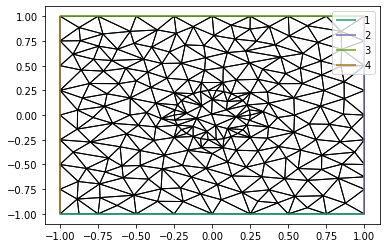

In [83]:
import meshpy.triangle as triangle

def round_trip_connect(start, end):
    return [(i, i+1) for i in range(start, end)] + [(end, start)]

def make_mesh():
    points = [(-1, -1), (1, -1), (1, 1), (-1, 1)]
    facets = round_trip_connect(0, len(points)-1)
    facet_markers = [1, 2, 3, 4]

    circ_start = len(points)
    nsegments = 30
    points.extend(
            (0.25 * np.cos(angle), 0.25 * np.sin(angle))
            for angle in np.linspace(0, 2*np.pi, nsegments, endpoint=False))

    facets.extend(round_trip_connect(circ_start, len(points)-1))
    facet_markers.extend([-1] * nsegments)

    def needs_refinement(vertices, area):
        bary = np.sum(np.array(vertices), axis=0)/3
        max_area = 0.01 + la.norm(bary, np.inf)*0.01
        return bool(area > max_area)

    info = triangle.MeshInfo()
    info.set_points(points)
    info.set_facets(facets, facet_markers=facet_markers)

    built_mesh = triangle.build(info, refinement_func=needs_refinement)
    plex = fd_mesh._from_cell_list(
        2, np.array(built_mesh.elements), np.array(built_mesh.points), COMM_WORLD)

    import firedrake.cython.dmplex as dmplex

    v_start, v_end = plex.getDepthStratum(0)   # vertices
    for facet, fmarker in zip(built_mesh.facets, built_mesh.facet_markers):
        vertices = [fvert + v_start for fvert in facet]
        if fmarker > 0:  # interior facets are negative above
            join = plex.getJoin(vertices)
            plex.setLabelValue(dmplex.FACE_SETS_LABEL, join[0], fmarker)

    return Mesh(plex)
    
mesh = make_mesh()

triplot(mesh)
plt.legend()

## Function Space

In [84]:
V = FunctionSpace(mesh, 'Lagrange', 1)

## RHS and Coefficient

In [85]:
x = SpatialCoordinate(mesh)
f = conditional(le(sqrt(x[0]**2 + x[1]**2), 0.25), 25.0, 0.0)
kappa = conditional(le(sqrt(x[0]**2 + x[1]**2), 0.25), 25.0, 0.1)

## Boundary Conditions

In [93]:
g = interpolate(20.0 * (1-x[0]*x[0]), V)
bcg = DirichletBC(V, g, [1])
bcz = DirichletBC(V, 0.0, [2,3,4])
bc = [bcg, bcz]

## Symbolic *Trial* and *Test* Functions

In [94]:
#clear
u = TrialFunction(V)
v = TestFunction(V)

v

Argument(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f94865dcd50>, FiniteElement('Lagrange', triangle, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 27)), 0, None)

## Weak form

Pieces:

- `inner`
- `grad`
- `dx`

In [95]:
#clear
a = kappa*inner(grad(u), grad(v))*dx
L = f*v*dx

## Solve and Plot

In [96]:
U = Function(V)
solve(a == L, U, bc)

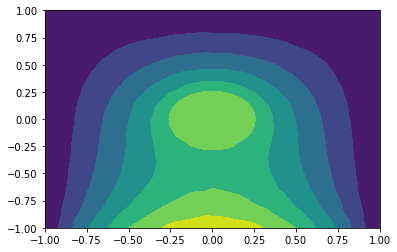

In [97]:
tricontourf(U)

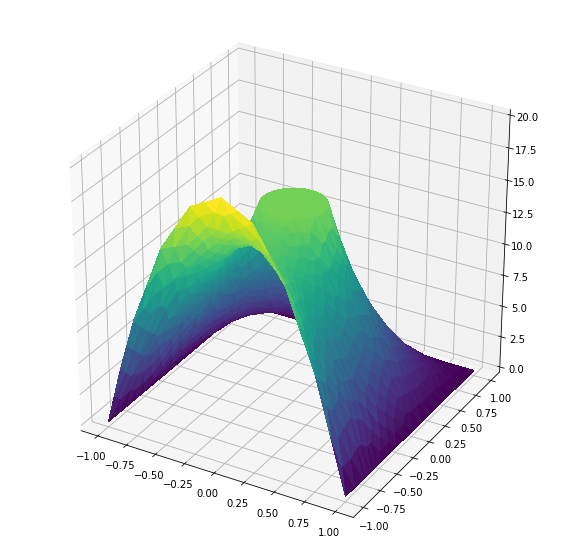

In [92]:
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(111, projection='3d')
trisurf(U, axes=axes)